In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [5]:
# Load the data and create engineered features
df = pd.read_csv('../../data/data.csv')
# Convert date columns to datetime
df[["observation_date", "date_of_introduction"]] = df[["observation_date", "date_of_introduction"]].apply(
    pd.to_datetime
)
# create number of days since introduction feature
df['days_since_introduction'] = (df['observation_date'] - df['date_of_introduction']).dt.days
df['initial_growth_potential'] = df['initial_female_count'] * df['leaf_area_cm2']

In [6]:
features = [
    'initial_female_count',
    'leaf_area_cm2',
    'population_density',
    'days_since_introduction',
    'initial_growth_potential'
]
target = 'cumulative_mite_count'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- Create and Train the XGBoost Model ---
# Using common default parameters for a strong baseline
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
                             max_depth=5, subsample=0.8, random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# --- Make Predictions and Evaluate ---
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mean_squared_error_xgb = mean_squared_error(y_test, y_pred_xgb)
root_mean_squared_error_xgb = root_mean_squared_error(y_test, y_pred_xgb)


# --- Print the Results and Final Comparison ---
print("--- XGBoost Regressor Performance ---")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}\n")
print(f"Mean Squared Error (MSE): {mean_squared_error_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error_xgb:.2f}\n")
print(f"R-squared (R²): {r2_xgb:.4f}")

--- XGBoost Regressor Performance ---
Mean Absolute Error (MAE): 34.55

Mean Squared Error (MSE): 3783.99
Root Mean Squared Error (RMSE): 61.51

R-squared (R²): 0.8092


In [8]:
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000 , 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized search
xgb_random = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=500,  # Number of combinations to try
    scoring='r2',
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit the RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get the best model
best_xgb_model = xgb_random.best_estimator_

# Print the best parameters
print("Best parameters found:")
for param, value in xgb_random.best_params_.items():
    print(f"{param}: {value}")

# Evaluate the tuned model on the test set
y_pred_tuned = best_xgb_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mean_squared_error_tuned = mean_squared_error(y_test, y_pred_tuned)
root_mean_squared_error_tuned = root_mean_squared_error(y_test, y_pred_tuned)

print("\n--- Tuned XGBoost Performance ---")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error_tuned:.2f}")
print(f"R-squared (R²): {r2_tuned:.4f}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found:
subsample: 0.8
n_estimators: 500
max_depth: 3
learning_rate: 0.05
colsample_bytree: 1.0

--- Tuned XGBoost Performance ---
Mean Absolute Error (MAE): 33.27
Mean Squared Error (MSE): 3270.59
Root Mean Squared Error (RMSE): 57.19
R-squared (R²): 0.8351


<Figure size 1000x600 with 0 Axes>

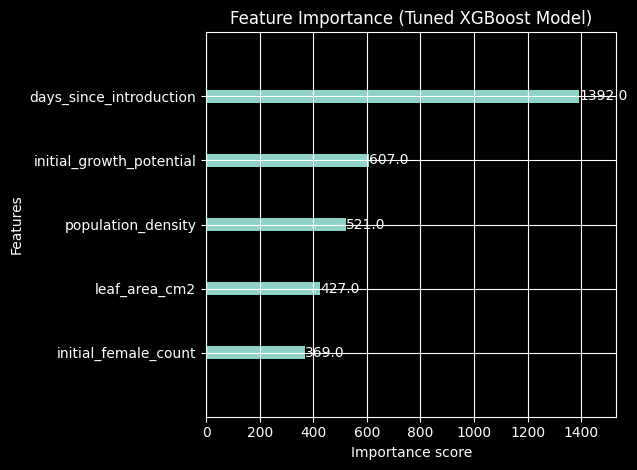

In [9]:
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb_model, max_num_features=10)
plt.title('Feature Importance (Tuned XGBoost Model)')
plt.tight_layout()
plt.show()

In [1]:
xgb_random.best_params_

NameError: name 'xgb_random' is not defined